In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import accuracy_score
from skimage.metrics import structural_similarity as ssim

random_seed = 40
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='data', train=False, download=True,transform=transform)

train_size, val_size = 0.9, 0.1
batch_size = 128

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Auto Encoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, bottle_neck_dimension=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3), 
            nn.ReLU(),
            nn.Flatten(),  
            nn.Linear(64 * 22 * 22, bottle_neck_dimension), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottle_neck_dimension, 64 * 22 * 22),  
            nn.ReLU(),
            nn.Unflatten(1, (64, 22, 22)), 
            nn.ConvTranspose2d(64, 32, kernel_size=3),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3), 
            nn.Tanh()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint( model)
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [4]:
model = Autoencoder()
loss_fn = criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Utilising",device)
model = model.to(device)
model_path = 'models/ae.pt'
early_stopping = EarlyStopping(patience=5, path=model_path)

print("Training........")
for epoch_num in range(25):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}", total=len(train_loader))

    for batch_num, (input, labels) in enumerate(progress_bar):
        (input, labels) = (input.to(device), labels.to(device))
        pred = model(input)
        loss = loss_fn(pred, input)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss /= len(train_loader)
    model.eval()

    with torch.no_grad():
        val_loss = 0
        for batch_num, (input, labels) in enumerate(val_loader):
            (input, labels) = (input.to(device), labels.to(device))
            pred = model(input)
            val_loss += loss_fn(pred, input)
        val_loss /= len(val_loader)

    if epoch_num % 1 == 0:
        print(f"Epoch {epoch_num}, Train Loss: {epoch_loss}, Val Loss: {val_loss}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping....")
        break
print("Best val loss is",early_stopping.best_score)

Utilising cuda
Training........


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:23<00:00, 17.75it/s, loss=0.0202]


Epoch 0, Train Loss: 0.05667869297796375, Val Loss: 0.018767114728689194


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.0127]


Epoch 1, Train Loss: 0.014970353389626713, Val Loss: 0.012435706332325935


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.36it/s, loss=0.00959]


Epoch 2, Train Loss: 0.010669663190947608, Val Loss: 0.009481982327997684


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.48it/s, loss=0.00848]


Epoch 3, Train Loss: 0.009006980087131402, Val Loss: 0.008716662414371967


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00887]


Epoch 4, Train Loss: 0.008230864500706371, Val Loss: 0.008342944085597992


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.39it/s, loss=0.0084]


Epoch 5, Train Loss: 0.007642961850928328, Val Loss: 0.008183023892343044


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.38it/s, loss=0.00714]


Epoch 6, Train Loss: 0.007206562558912906, Val Loss: 0.007320489268749952


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00628]


Epoch 7, Train Loss: 0.006942616281280585, Val Loss: 0.006926373578608036


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.50it/s, loss=0.00691]


Epoch 8, Train Loss: 0.006628131151852591, Val Loss: 0.007073782850056887


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00634]


Epoch 9, Train Loss: 0.006363159376615879, Val Loss: 0.006920145358890295


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00592]


Epoch 10, Train Loss: 0.006166587498754051, Val Loss: 0.006509554106742144


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.39it/s, loss=0.00624]


Epoch 11, Train Loss: 0.00596683374186757, Val Loss: 0.006368949078023434


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.40it/s, loss=0.00556]


Epoch 12, Train Loss: 0.0058302371365446335, Val Loss: 0.006285380106419325


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.40it/s, loss=0.00661]


Epoch 13, Train Loss: 0.0057279315040009845, Val Loss: 0.006241913419216871


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.37it/s, loss=0.00552]


Epoch 14, Train Loss: 0.005505483297375141, Val Loss: 0.005838149692863226


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.40it/s, loss=0.00531]


Epoch 15, Train Loss: 0.00534304848461637, Val Loss: 0.006081205327063799


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.51it/s, loss=0.00504]


Epoch 16, Train Loss: 0.005228176345536706, Val Loss: 0.00583655945956707


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00545]


Epoch 17, Train Loss: 0.005106245206174621, Val Loss: 0.005570956040173769


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.48it/s, loss=0.00487]


Epoch 18, Train Loss: 0.0049640234036733046, Val Loss: 0.00564075680449605


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.55it/s, loss=0.00534]


Epoch 19, Train Loss: 0.004904931455285628, Val Loss: 0.005637903697788715


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.56it/s, loss=0.00453]


Epoch 20, Train Loss: 0.004761103414864195, Val Loss: 0.005490321200340986


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.44it/s, loss=0.00446]


Epoch 21, Train Loss: 0.004685811840783434, Val Loss: 0.005396382417529821


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.42it/s, loss=0.00481]


Epoch 22, Train Loss: 0.004598074541890649, Val Loss: 0.005356787703931332


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.41it/s, loss=0.00419]


Epoch 23, Train Loss: 0.004537867837898892, Val Loss: 0.005385107826441526


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.49it/s, loss=0.00453]


Epoch 24, Train Loss: 0.004432540208154239, Val Loss: 0.005392236169427633
Best val loss is tensor(0.0054, device='cuda:0')


In [8]:
model = Autoencoder()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Utilising",device)
model = model.to(device)
model_path = 'models/ae.pt'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

ssim_scores = []
with torch.no_grad():
    for input_images, _ in tqdm(test_loader):
        input_images = input_images.to(device)
        output_images = model(input_images)
        input_images_np = input_images.permute(0, 2, 3, 1).cpu().numpy()
        output_images_np = output_images.permute(0, 2, 3, 1).cpu().numpy()
        batch_ssim_scores = ssim(input_images_np, output_images_np, data_range=output_images_np.max() - output_images_np.min(),channel_axis=-1)
        ssim_scores.append(batch_ssim_scores)
ssim_temp = np.mean(ssim_scores)
print(ssim_temp)

Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 19.47it/s]

0.9877505


# Result
Similarity score for base Auto encoder model is 0.98

# Auto encoder with gaussian noise images

In [9]:
def add_gaussian_noise(images, sigma):
    noise = np.random.normal(loc=0, scale=sigma, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0, 1)  
    return noisy_images

In [10]:
sigmas = [0.25,0.5,0.75]
for sigma in sigmas:
    print("Training with noisgy data, sigma ="+str(sigma))
    model = Autoencoder()
    loss_fn = criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Utilising",device)
    model = model.to(device)
    model_path = 'models/ae_noise_'+str(sigma)+'.pt'
    early_stopping = EarlyStopping(patience=5, path=model_path)

    print("Adding gaussian noise")
    noisy_train_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in train_loader]
    noisy_val_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in val_loader]
    
    print("Training........")
    for epoch_num in range(20):
        model.train()
        epoch_loss = 0
      

        progress_bar = tqdm(noisy_train_data, desc=f"Epoch {epoch_num}", total=len(train_loader))
        for batch_num, (input, _) in enumerate(progress_bar):
            input = torch.tensor(input).float()
            input = input.to(device)
            pred = model(input)
            loss = loss_fn(pred, input)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
    
        epoch_loss /= len(train_loader)
        model.eval()
    
        with torch.no_grad():
            val_loss = 0
            for batch_num, (input, labels) in enumerate(noisy_val_data):
                input = torch.tensor(input).float()
                (input, labels) = (input.to(device), labels.to(device))
                pred = model(input)
                val_loss += loss_fn(pred, input)
            val_loss /= len(val_loader)
    
        if epoch_num % 1 == 0:
            print(f"Epoch {epoch_num}, Train Loss: {epoch_loss}, Val Loss: {val_loss}")
    
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping....")
            break
    print("Best val loss is",early_stopping.best_score)

Training with noisgy data, sigma =0.25
Utilising cuda
Adding gaussian noise
Training........


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.24it/s, loss=0.00902]


Epoch 0, Train Loss: 0.017592732042021237, Val Loss: 0.008796132169663906


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 58.17it/s, loss=0.00693]


Epoch 1, Train Loss: 0.007720148225063326, Val Loss: 0.006976762320846319


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 59.01it/s, loss=0.00615]


Epoch 2, Train Loss: 0.006634387613596368, Val Loss: 0.0065934136509895325


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.60it/s, loss=0.00589]


Epoch 3, Train Loss: 0.006140648391786345, Val Loss: 0.005989500787109137


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.97it/s, loss=0.00546]


Epoch 4, Train Loss: 0.00582212295440595, Val Loss: 0.005937919951975346


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.42it/s, loss=0.00553]


Epoch 5, Train Loss: 0.0056296536164861435, Val Loss: 0.005657604895532131


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.56it/s, loss=0.00522]


Epoch 6, Train Loss: 0.005476457585461473, Val Loss: 0.005590980872511864


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.35it/s, loss=0.00505]


Epoch 7, Train Loss: 0.005347857699769227, Val Loss: 0.0057270037941634655


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.59it/s, loss=0.0049]


Epoch 8, Train Loss: 0.0052350610869790985, Val Loss: 0.0053712185472249985


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.58it/s, loss=0.00494]


Epoch 9, Train Loss: 0.005150424829635646, Val Loss: 0.005442766938358545


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.57it/s, loss=0.00482]


Epoch 10, Train Loss: 0.005048190683823838, Val Loss: 0.005569737870246172


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.57it/s, loss=0.00489]


Epoch 11, Train Loss: 0.005011324044670115, Val Loss: 0.005340599920600653


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.59it/s, loss=0.00455]


Epoch 12, Train Loss: 0.0049638423342610845, Val Loss: 0.0055768247693777084


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.29it/s, loss=0.00448]


Epoch 13, Train Loss: 0.00489876241648296, Val Loss: 0.0055013252422213554


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.36it/s, loss=0.00493]


Epoch 14, Train Loss: 0.004873540260171368, Val Loss: 0.005289773922413588


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.05it/s, loss=0.00476]


Epoch 15, Train Loss: 0.004808588985185982, Val Loss: 0.005606676451861858


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.23it/s, loss=0.00445]


Epoch 16, Train Loss: 0.004763583360257519, Val Loss: 0.005526203196495771


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.60it/s, loss=0.00449]


Epoch 17, Train Loss: 0.004749780519693313, Val Loss: 0.005300593096762896


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 59.29it/s, loss=0.0043]


Epoch 18, Train Loss: 0.004753916574006468, Val Loss: 0.005284844897687435


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 59.26it/s, loss=0.00434]


Epoch 19, Train Loss: 0.00469564019936309, Val Loss: 0.005195452831685543
Best val loss is tensor(0.0052, device='cuda:0')
Training with noisgy data, sigma =0.5
Utilising cuda
Adding gaussian noise
Training........


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.70it/s, loss=0.0267]


Epoch 0, Train Loss: 0.0348489405278346, Val Loss: 0.026557087898254395


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 58.37it/s, loss=0.0243]


Epoch 1, Train Loss: 0.02536985606961482, Val Loss: 0.024235200136899948


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.81it/s, loss=0.0232]


Epoch 2, Train Loss: 0.023778398402070546, Val Loss: 0.023178229108452797


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 58.42it/s, loss=0.0226]


Epoch 3, Train Loss: 0.02291632720856305, Val Loss: 0.022682365030050278


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.77it/s, loss=0.0221]


Epoch 4, Train Loss: 0.022356512276588174, Val Loss: 0.022308126091957092


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.77it/s, loss=0.0218]


Epoch 5, Train Loss: 0.021985935047268867, Val Loss: 0.022277014330029488


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.97it/s, loss=0.0214]


Epoch 6, Train Loss: 0.02174423649130274, Val Loss: 0.021800504997372627


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 59.30it/s, loss=0.0212]


Epoch 7, Train Loss: 0.021458504081513927, Val Loss: 0.021676285192370415


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 59.26it/s, loss=0.021]


Epoch 8, Train Loss: 0.021227329664850404, Val Loss: 0.02155005931854248


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 58.29it/s, loss=0.0209]


Epoch 9, Train Loss: 0.021036088131191608, Val Loss: 0.021431123837828636


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.14it/s, loss=0.0209]


Epoch 10, Train Loss: 0.020906657611695228, Val Loss: 0.021349430084228516


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.61it/s, loss=0.0207]


Epoch 11, Train Loss: 0.020911583716658903, Val Loss: 0.02123541384935379


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.56it/s, loss=0.0205]


Epoch 12, Train Loss: 0.02080968641609801, Val Loss: 0.02130040153861046


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.42it/s, loss=0.0204]


Epoch 13, Train Loss: 0.020622617022191744, Val Loss: 0.021164651960134506


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.20it/s, loss=0.0203]


Epoch 14, Train Loss: 0.020452229526794354, Val Loss: 0.02105886861681938


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.20it/s, loss=0.0202]


Epoch 15, Train Loss: 0.02030465586808338, Val Loss: 0.021032409742474556


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.12it/s, loss=0.02]


Epoch 16, Train Loss: 0.02017752420139539, Val Loss: 0.021002531051635742


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.62it/s, loss=0.02]


Epoch 17, Train Loss: 0.02010816698496658, Val Loss: 0.021000269800424576


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.56it/s, loss=0.02]


Epoch 18, Train Loss: 0.020059667395260095, Val Loss: 0.020951740443706512


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.63it/s, loss=0.0199]


Epoch 19, Train Loss: 0.02001878745430171, Val Loss: 0.020970813930034637
Best val loss is tensor(0.0210, device='cuda:0')
Training with noisgy data, sigma =0.75
Utilising cuda
Adding gaussian noise
Training........


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.49it/s, loss=0.0372]


Epoch 0, Train Loss: 0.04332340412477464, Val Loss: 0.035767920315265656


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.43it/s, loss=0.0358]


Epoch 1, Train Loss: 0.03519002729541318, Val Loss: 0.03442980349063873


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.49it/s, loss=0.0351]


Epoch 2, Train Loss: 0.034302217462122156, Val Loss: 0.03388630971312523


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.56it/s, loss=0.0348]


Epoch 3, Train Loss: 0.03379356091338876, Val Loss: 0.03411896526813507


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.57it/s, loss=0.0344]


Epoch 4, Train Loss: 0.033460494457474815, Val Loss: 0.03355775773525238


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.22it/s, loss=0.034]


Epoch 5, Train Loss: 0.03320245153460458, Val Loss: 0.033315226435661316


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.33it/s, loss=0.0338]


Epoch 6, Train Loss: 0.03299396424179111, Val Loss: 0.033083993941545486


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.92it/s, loss=0.0338]


Epoch 7, Train Loss: 0.03283441968491716, Val Loss: 0.03309463709592819


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.43it/s, loss=0.0337]


Epoch 8, Train Loss: 0.03271711800000255, Val Loss: 0.03301987797021866


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.32it/s, loss=0.0337]


Epoch 9, Train Loss: 0.032624945574179644, Val Loss: 0.03306172043085098


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.70it/s, loss=0.0334]


Epoch 10, Train Loss: 0.032520282792889675, Val Loss: 0.03328833729028702


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.53it/s, loss=0.0334]


Epoch 11, Train Loss: 0.0324179617979374, Val Loss: 0.033071719110012054


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.58it/s, loss=0.033]


Epoch 12, Train Loss: 0.032363086872650264, Val Loss: 0.0332498699426651


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00, 57.79it/s, loss=0.0329]


Epoch 13, Train Loss: 0.03226183632927201, Val Loss: 0.033119793981313705
Early stopping....
Best val loss is tensor(0.0330, device='cuda:0')


In [11]:
sigmas = [0.25,0.5,0.75]
avg_ssim = []
for sigma in sigmas:
    print("Testing with sigma=",sigma)
    model = Autoencoder()
    print("Adding gaussian noise")
    noisy_test_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in test_loader]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Utilising",device)
    model = model.to(device)
    model_path = 'models/ae_noise_'+str(sigma)+'.pt'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    
    ssim_scores = []
    with torch.no_grad():
        for input_images, _ in tqdm(noisy_test_data):
            input_images = torch.tensor(input_images).float()
            input_images = input_images.to(device)
            output_images = model(input_images)
            input_images_np = input_images.permute(0, 2, 3, 1).cpu().numpy()
            output_images_np = output_images.permute(0, 2, 3, 1).cpu().numpy()
            batch_ssim_scores = ssim(input_images_np, output_images_np, data_range=output_images_np.max() - output_images_np.min(),channel_axis=-1)
            ssim_scores.append(batch_ssim_scores)
    ssim_temp = np.mean(ssim_scores)
    avg_ssim.append(ssim_temp)
    

Testing with sigma= 0.25
Adding gaussian noise
Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.24it/s]


Testing with sigma= 0.5
Adding gaussian noise
Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.52it/s]


Testing with sigma= 0.75
Adding gaussian noise
Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.89it/s]


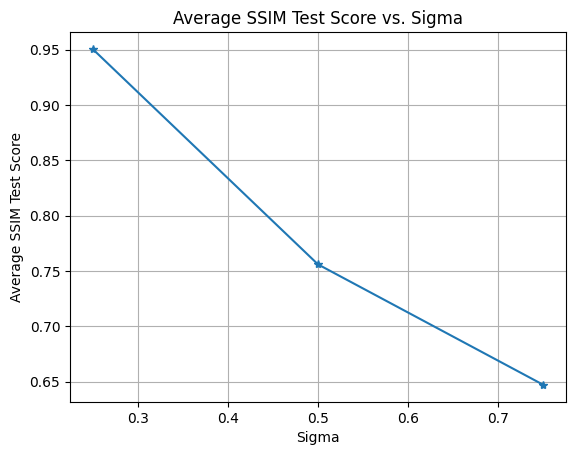

In [12]:
import matplotlib.pyplot as plt
plt.plot(sigmas, avg_ssim, marker='*')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score vs. Sigma')
plt.grid(True)
plt.show()

# Observations
1. As noise variance increases there is a drop in similairty score.
2. As variance increases randomness increases in the data making it difficult for the model to learn, lesser the randomness higher the learning.

# Autoencoder with different bottleneck dimensions

In [13]:
sigma = 0.25
bottle_neck_dimensions = [256, 512, 768]
print("Adding gaussian noise")
noisy_train_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in train_loader]
noisy_val_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in val_loader]
noisy_test_data = [(add_gaussian_noise(images.numpy(), sigma), labels) for images, labels in test_loader]

for bottle_neck_dimension in bottle_neck_dimensions:
    print("Training with noisgy data, d="+str(bottle_neck_dimension))
    model = Autoencoder(bottle_neck_dimension=bottle_neck_dimension)
    loss_fn = criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Utilising",device)
    model = model.to(device)
    model_path = 'models/ae_noise_'+str(sigma)+'_'+str(bottle_neck_dimension)+'.pt'
    early_stopping = EarlyStopping(patience=5, path=model_path)

    
    print("Training........")
    for epoch_num in range(20):
        model.train()
        epoch_loss = 0
      

        progress_bar = tqdm(noisy_train_data, desc=f"Epoch {epoch_num}", total=len(train_loader))
        for batch_num, (input, _) in enumerate(progress_bar):
            input = torch.tensor(input).float()
            input = input.to(device)
            pred = model(input)
            loss = loss_fn(pred, input)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
    
        epoch_loss /= len(train_loader)
        model.eval()
    
        with torch.no_grad():
            val_loss = 0
            for batch_num, (input, labels) in enumerate(noisy_val_data):
                input = torch.tensor(input).float()
                (input, labels) = (input.to(device), labels.to(device))
                pred = model(input)
                val_loss += loss_fn(pred, input)
            val_loss /= len(val_loader)
    
        if epoch_num % 1 == 0:
            print(f"Epoch {epoch_num}, Train Loss: {epoch_loss}, Val Loss: {val_loss}")
    
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping....")
            break
    print("Best val loss is",early_stopping.best_score)
    

Adding gaussian noise
Training with noisgy data, d=256
Utilising cuda
Training........


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.39it/s, loss=0.00701]


Epoch 0, Train Loss: 0.015421570898850242, Val Loss: 0.006745513062924147


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.39it/s, loss=0.00509]


Epoch 1, Train Loss: 0.005585604710327858, Val Loss: 0.004914213437587023


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.45it/s, loss=0.0039]


Epoch 2, Train Loss: 0.004279309744677414, Val Loss: 0.004099525976926088


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.36it/s, loss=0.00351]


Epoch 3, Train Loss: 0.0036865971431851176, Val Loss: 0.003639655653387308


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.37it/s, loss=0.00346]


Epoch 4, Train Loss: 0.0033498084298401224, Val Loss: 0.0032770968973636627


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.36it/s, loss=0.00308]


Epoch 5, Train Loss: 0.0031586536151131887, Val Loss: 0.0032840559724718332


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.48it/s, loss=0.00312]


Epoch 6, Train Loss: 0.003006593901355049, Val Loss: 0.0031349940691143274


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.46it/s, loss=0.00294]


Epoch 7, Train Loss: 0.0029286021296093816, Val Loss: 0.0031775617972016335


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.46it/s, loss=0.00291]


Epoch 8, Train Loss: 0.002821720638356538, Val Loss: 0.0030851587653160095


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:08<00:00, 46.98it/s, loss=0.00298]


Epoch 9, Train Loss: 0.00278286144834771, Val Loss: 0.0029570655897259712


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.56it/s, loss=0.0027]


Epoch 10, Train Loss: 0.002718398054527622, Val Loss: 0.0029945874121040106


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.42it/s, loss=0.00252]


Epoch 11, Train Loss: 0.00263691518093808, Val Loss: 0.0028413082472980022


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.40it/s, loss=0.00256]


Epoch 12, Train Loss: 0.0025711736522650267, Val Loss: 0.002849370473995805


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.55it/s, loss=0.0025]


Epoch 13, Train Loss: 0.0025580962496408, Val Loss: 0.002949449932202697


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.10it/s, loss=0.00269]


Epoch 14, Train Loss: 0.0025301685510423933, Val Loss: 0.0028539958875626326


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.34it/s, loss=0.00274]


Epoch 15, Train Loss: 0.002469063531806013, Val Loss: 0.0029504483100026846


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.01it/s, loss=0.0027]


Epoch 16, Train Loss: 0.002424589049852325, Val Loss: 0.003141263034194708
Early stopping....
Best val loss is tensor(0.0028, device='cuda:0')
Training with noisgy data, d=512
Utilising cuda
Training........


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.16it/s, loss=0.00643]


Epoch 0, Train Loss: 0.015612960113344882, Val Loss: 0.006202372256666422


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.07it/s, loss=0.00426]


Epoch 1, Train Loss: 0.005114527111343368, Val Loss: 0.00418202904984355


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.07it/s, loss=0.00355]


Epoch 2, Train Loss: 0.0038100211004951697, Val Loss: 0.0035868710838258266


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.09it/s, loss=0.00316]


Epoch 3, Train Loss: 0.0032072754585629956, Val Loss: 0.0030337045900523663


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.06it/s, loss=0.00268]


Epoch 4, Train Loss: 0.0028416111136199598, Val Loss: 0.003214666387066245


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.91it/s, loss=0.00275]


Epoch 5, Train Loss: 0.0026138092460711066, Val Loss: 0.002653659088537097


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.90it/s, loss=0.00229]


Epoch 6, Train Loss: 0.0024273057983552606, Val Loss: 0.002447495935484767


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.89it/s, loss=0.00228]


Epoch 7, Train Loss: 0.002311975025390915, Val Loss: 0.0025264816358685493


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.94it/s, loss=0.00233]


Epoch 8, Train Loss: 0.00222938414304451, Val Loss: 0.002342633670195937


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.89it/s, loss=0.00205]


Epoch 9, Train Loss: 0.002140408741272721, Val Loss: 0.002356013748794794


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.93it/s, loss=0.00219]


Epoch 10, Train Loss: 0.0020745721840414425, Val Loss: 0.002484031254425645


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.00it/s, loss=0.00211]


Epoch 11, Train Loss: 0.002017571675255718, Val Loss: 0.0024605761282145977


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.07it/s, loss=0.00215]


Epoch 12, Train Loss: 0.001980747711972744, Val Loss: 0.0023296214640140533


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.09it/s, loss=0.00196]


Epoch 13, Train Loss: 0.0019354184262423612, Val Loss: 0.002343570813536644


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.07it/s, loss=0.00205]


Epoch 14, Train Loss: 0.001896838395761423, Val Loss: 0.0024015503004193306


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.94it/s, loss=0.00181]


Epoch 15, Train Loss: 0.0018854573701720207, Val Loss: 0.002347724512219429


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.86it/s, loss=0.00181]


Epoch 16, Train Loss: 0.0018275119598747465, Val Loss: 0.0022816751152276993


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 32.82it/s, loss=0.00175]


Epoch 17, Train Loss: 0.0018144095640947326, Val Loss: 0.002309707459062338


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.09it/s, loss=0.00184]


Epoch 18, Train Loss: 0.0017972632200386534, Val Loss: 0.002293619327247143


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 33.09it/s, loss=0.00176]


Epoch 19, Train Loss: 0.0017459811835871984, Val Loss: 0.002278790809214115
Best val loss is tensor(0.0023, device='cuda:0')
Training with noisgy data, d=768
Utilising cuda
Training........


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.57it/s, loss=0.00726]


Epoch 0, Train Loss: 0.01669595489649199, Val Loss: 0.007072741631418467


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.48it/s, loss=0.00491]


Epoch 1, Train Loss: 0.0055901025338054265, Val Loss: 0.004948627669364214


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.57it/s, loss=0.00359]


Epoch 2, Train Loss: 0.0040340320117798105, Val Loss: 0.0036403259728103876


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.50it/s, loss=0.00323]


Epoch 3, Train Loss: 0.0033074782485963327, Val Loss: 0.003172192955389619


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.49it/s, loss=0.00264]


Epoch 4, Train Loss: 0.00285681892490959, Val Loss: 0.002774057211354375


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.49it/s, loss=0.00232]


Epoch 5, Train Loss: 0.002550652884586904, Val Loss: 0.002450523665174842


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.52it/s, loss=0.00218]


Epoch 6, Train Loss: 0.002317066836530581, Val Loss: 0.00247485120780766


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.57it/s, loss=0.00203]


Epoch 7, Train Loss: 0.00212627137714326, Val Loss: 0.002199356909841299


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.48it/s, loss=0.00193]


Epoch 8, Train Loss: 0.0019893925573557653, Val Loss: 0.002170245861634612


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.48it/s, loss=0.00186]


Epoch 9, Train Loss: 0.0018824552598528529, Val Loss: 0.0020877630449831486


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.40it/s, loss=0.00177]


Epoch 10, Train Loss: 0.0017832324128946669, Val Loss: 0.0020845946855843067


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.35it/s, loss=0.00163]


Epoch 11, Train Loss: 0.0017115102774106071, Val Loss: 0.0019345174077898264


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.49it/s, loss=0.00151]


Epoch 12, Train Loss: 0.0016434529944658455, Val Loss: 0.0018265984253957868


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.56it/s, loss=0.00154]


Epoch 13, Train Loss: 0.001590822803759197, Val Loss: 0.0018184991786256433


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.58it/s, loss=0.00144]


Epoch 14, Train Loss: 0.0015572795900405867, Val Loss: 0.001764449174515903


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.77it/s, loss=0.00142]


Epoch 15, Train Loss: 0.001524760298181537, Val Loss: 0.0017641754820942879


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:16<00:00, 24.89it/s, loss=0.00141]


Epoch 16, Train Loss: 0.0014772505562319928, Val Loss: 0.0017869153525680304


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:16<00:00, 24.93it/s, loss=0.00142]


Epoch 17, Train Loss: 0.001441097991834549, Val Loss: 0.0017543126596137881


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.58it/s, loss=0.00137]


Epoch 18, Train Loss: 0.0014326598413037003, Val Loss: 0.001973707228899002


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:17<00:00, 24.53it/s, loss=0.00156]


Epoch 19, Train Loss: 0.0014023880101298974, Val Loss: 0.0017712871776893735
Best val loss is tensor(0.0018, device='cuda:0')


In [16]:
avg_ssim = []
for bottle_neck_dimension in bottle_neck_dimensions:
    model = Autoencoder(bottle_neck_dimension=bottle_neck_dimension)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Utilising",device)
    model = model.to(device)
    model_path = 'models/ae_noise_'+str(sigma)+'_'+str(bottle_neck_dimension)+'.pt'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    
    ssim_scores = []
    with torch.no_grad():
        for input_images, _ in tqdm(noisy_test_data):
            input_images = torch.tensor(input_images).float()
            input_images = input_images.to(device)
            output_images = model(input_images)
            input_images_np = input_images.permute(0, 2, 3, 1).cpu().numpy()
            output_images_np = output_images.permute(0, 2, 3, 1).cpu().numpy()
            batch_ssim_scores = ssim(input_images_np, output_images_np, data_range=output_images_np.max() - output_images_np.min(),channel_axis=-1)
            ssim_scores.append(batch_ssim_scores)
    ssim_temp = np.mean(ssim_scores)
    avg_ssim.append(ssim_temp)

Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.76it/s]


Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.90it/s]


Utilising cuda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.77it/s]


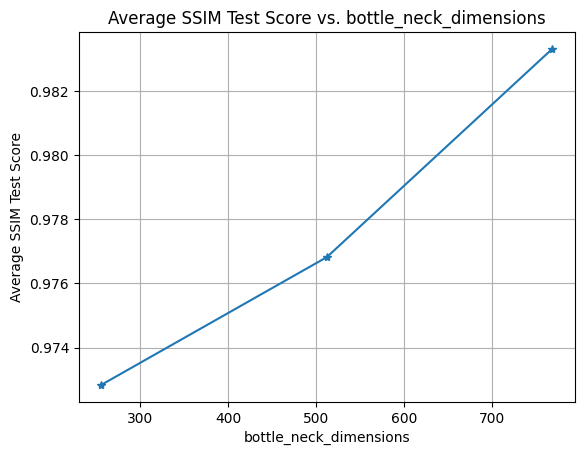

In [17]:
import matplotlib.pyplot as plt
plt.plot(bottle_neck_dimensions, avg_ssim, marker='*')
plt.xlabel('bottle_neck_dimensions')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score vs. bottle_neck_dimensions')
plt.grid(True)
plt.show()

# Observations
1. For a fixed variance, the performance increases as increase in bottle neck dimension
2. As dimension of bottleneck layer increases, it fecilitate the model to encode information very well resulting in better performance. 